# 西西学堂-机器学习训练营第四期-week01作业讲解

## 1. 数据介绍

## 2. 数据预处理

## 3. 模型介绍和使用

## 4. 参数优化

# 数据介绍

下载链接: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [3]:
# 包含的特征列、标签列
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# 只包含的特征列
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# 数据预处理
- 1. 对数值特征都取对数变换，变换后的数据更服从正太分布
- 2. 类别特征用dummpy实现one hot encoding
- 3. 缺失值用均值填充

In [5]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#### 对数变换

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a08f68898>,
      dtype=object)

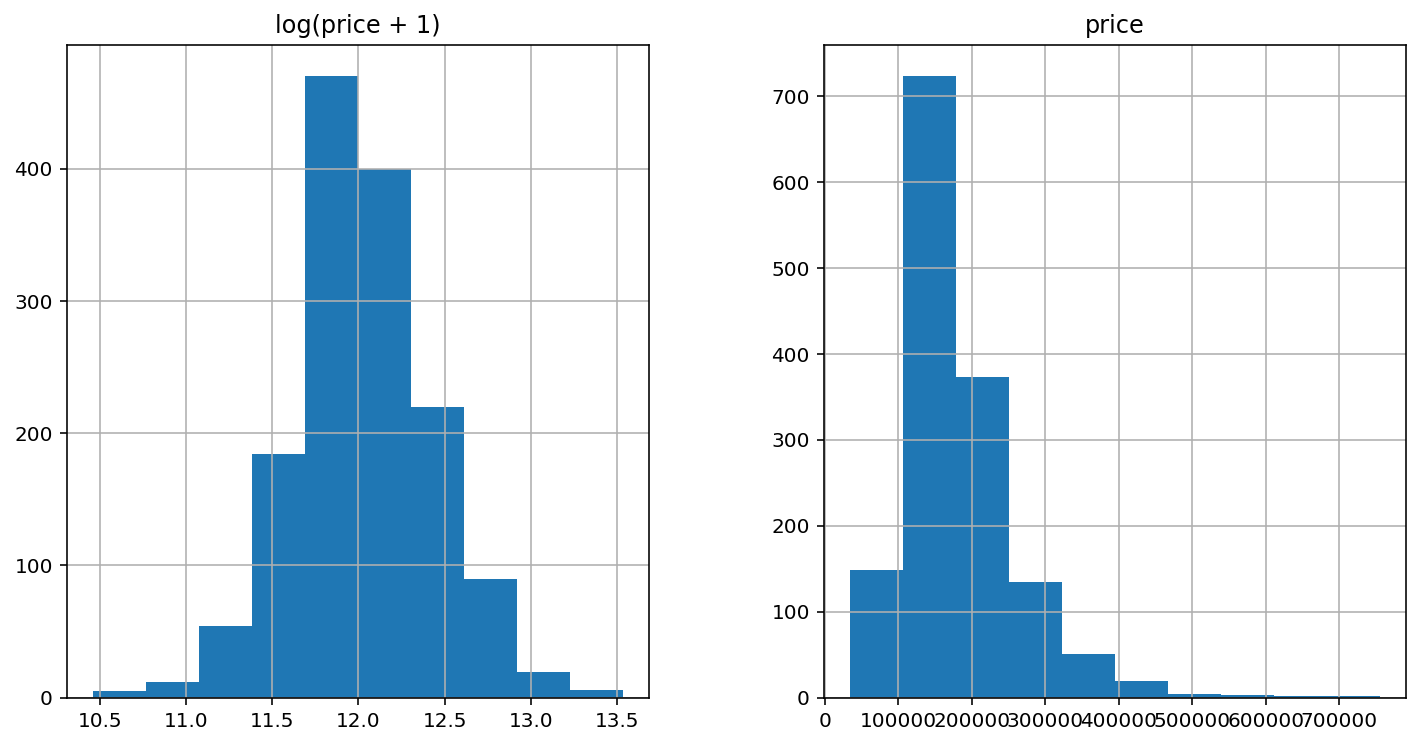

In [6]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [7]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

/Users/didi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log1p
  # This is added back by InteractiveShellApp.init_path()


#### 离散特征: one hot编码

In [8]:
all_data = pd.get_dummies(all_data)

#### 缺失值处理: 均值填充

In [9]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [10]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

# 模型介绍和使用

我们将使用带正则项的线性模型， 包括带L1正则项的Lasso, 和L2正则项的Ridge。

In [11]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

In [12]:
model_ridge = Ridge()

In [13]:
model_ridge.fit(X_train, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [14]:
pre = model_ridge.predict(X_test)
pre

array([11.69875466, 11.94385404, 12.13089642, ..., 12.06967712,
       11.68995658, 12.29814566])

# 参数优化

我们会使用一个交叉验证用来做超参数的选择。

In [57]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

岭回归模型一个重要的参数是alpha, 其越大则正则项的比重越大，过拟合的可能就越小。但是正则项的系数太大，模型的拟合能力又受到限制。

In [58]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

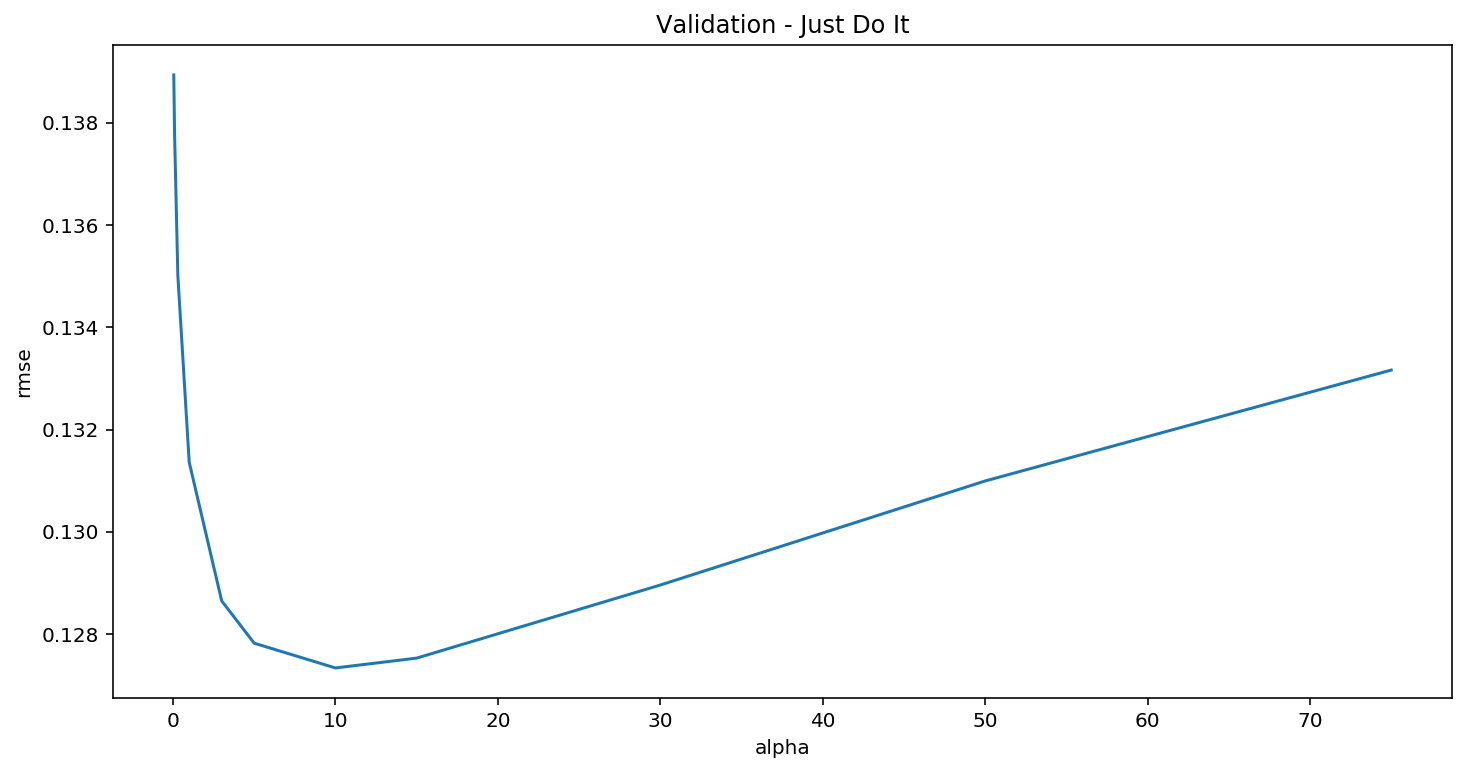

In [59]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

如上U形曲线，当alpha太大的时候，正则项的比重太大，则模型缺少拟合数据的能力。

但是，当alpha太小的时候，模型又开始容易过拟合

In [60]:
cv_ridge.min()

0.12733734668670768

Ridge, 得到的最优结果 = 0.127

接下来试试Lasso模型

In [72]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

LassoCV类的损失函数和损失函数的优化方法完全与Lasso类相同，区别在于验证方法。

验证方法：
LassoCV类对超参数α使用了交叉验证，来帮忙我们选择一个合适的α。在初始化LassoCV类时候，我们可以传一组备选的α值，10个，100个都可以。
LassoCV类会帮我们选择一个合适的α。免去了我们自己去一轮轮筛选α的苦恼。　

使用场景：　　
LassoCV类是进行Lasso回归的首选。当我们面临在一堆高位特征中找出主要特征时，LassoCV类更是必选。当面对稀疏线性关系时，LassoCV也很好用。

In [73]:
rmse_cv(model_lasso).mean()

0.12314421090977432

Lasso 的表现更好。 我们接下来用Lasso进行预测。

Lasso模型的好处是，模型在训练的同时为你做了特征选择。

其中越不重要的特征，其系数绝对值会越小，最小为0.

我们接下来看看各个特征的系数。

In [89]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [90]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


我们可以直接看看最重要的特征是哪些

In [91]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

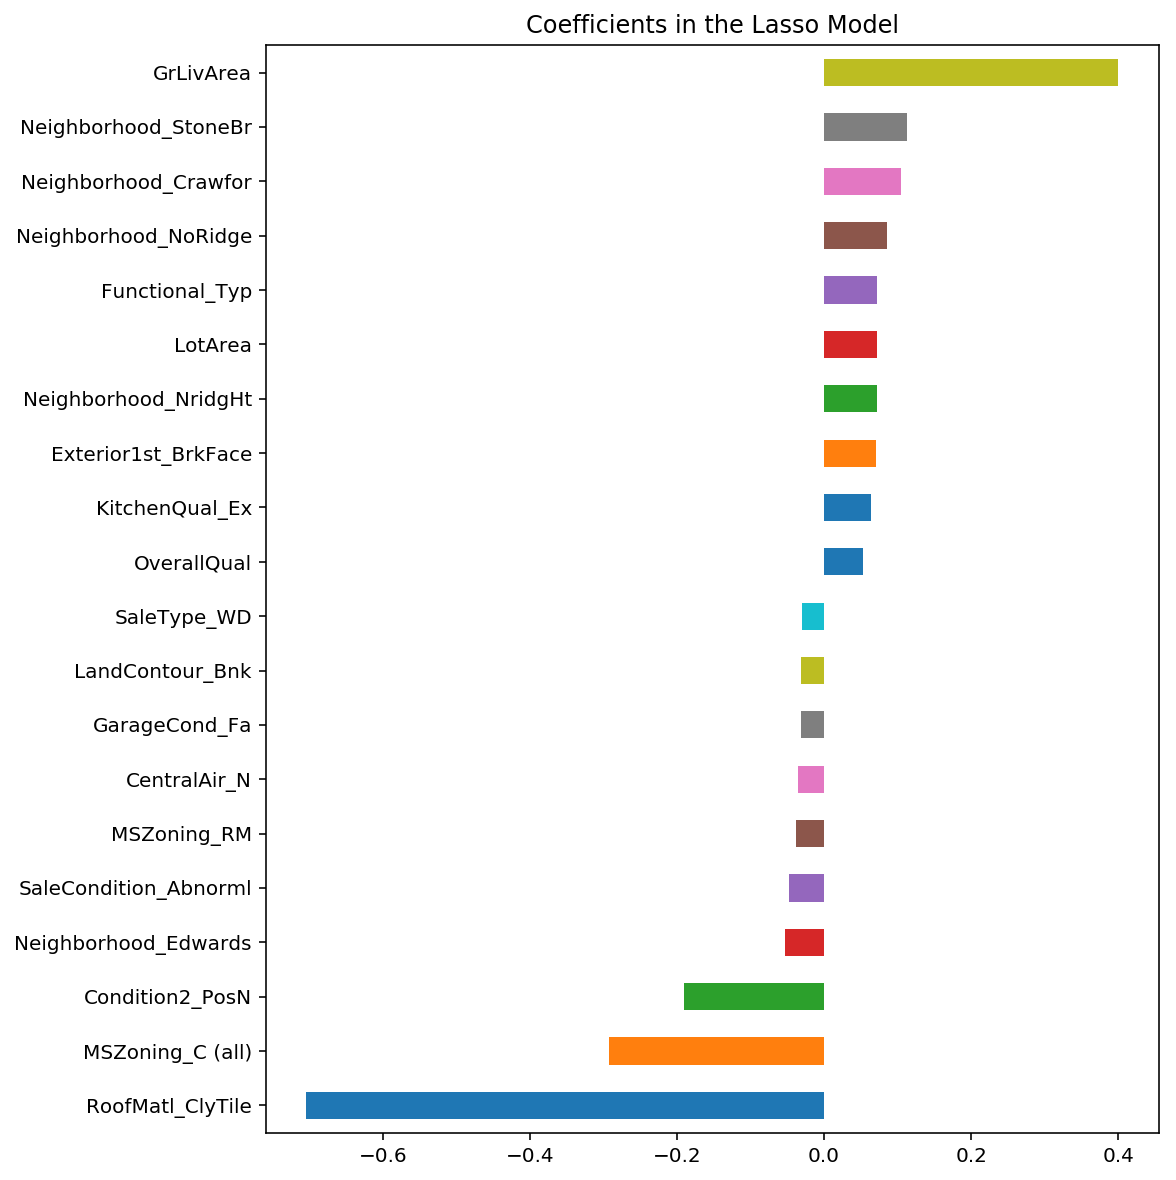

In [92]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

可以看出， Lasso认为最重要的特征是，GrLivArea, 这个是有道理的。

还有位置等特征。

Lasso最后学到的系数，具有明确的意义，可以直接看出特征的在线性模型中的权重。

（但是，由于我们做了log变换，所以这里实际数值大小的差异，也不能直接解释）

（而random forest里的特征重要性, 不具有那么明确的可解释意义）

我们可以生成最后的结果，提交到线上看看

In [93]:
preds = pd.DataFrame({"Id":test.Id, "SalePrice":model_lasso.predict(X_test)})
preds.to_csv('./submit.csv',index = False)